In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import pandas as pd
###

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# metadata
print(adult.metadata)

# variable information
print(adult.variables)

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

In [ ]:
### illustrate dataset
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


In [ ]:
y.value_counts()

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
dtype: int64

In [ ]:
### cleaning the whole datset
df = pd.concat([X, y], axis=1)
df_clean=df.dropna(subset=[X.columns[13],X.columns[6],X.columns[1]])
##
clean_x=df_clean.iloc[:,:14]
clean_y=df_clean.iloc[:,-1]



In [ ]:
### show the info of clean x and y
clean_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47621 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             47621 non-null  int64 
 1   workclass       47621 non-null  object
 2   fnlwgt          47621 non-null  int64 
 3   education       47621 non-null  object
 4   education-num   47621 non-null  int64 
 5   marital-status  47621 non-null  object
 6   occupation      47621 non-null  object
 7   relationship    47621 non-null  object
 8   race            47621 non-null  object
 9   sex             47621 non-null  object
 10  capital-gain    47621 non-null  int64 
 11  capital-loss    47621 non-null  int64 
 12  hours-per-week  47621 non-null  int64 
 13  native-country  47621 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.4+ MB


In [ ]:
clean_y.value_counts()

<=50K     24720
<=50K.    11360
>50K       7841
>50K.      3700
Name: income, dtype: int64

In [ ]:
### regenerate target label####
target_list=[]
for i in range(clean_y.values.shape[0]):
  if clean_y.values[i]=='<=50K' or clean_y.values[i]=='<=50K.':
    target_list.append(0)
  else:
    target_list.append(1)
target_list=np.array(target_list)
print(f' total <=50 k: {np.sum(target_list==0)},total >50k:{np.sum(target_list==1)}')

 total <=50 k: 36080,total >50k:11541


In [ ]:
### def function to calculate precision and recall
def PR_met(conf_mat):
  tn, fp, fn, tp = conf_mat.ravel()
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  F1 = 2 * (precision * recall) / (precision + recall)
  return(precision,recall,F1)

In [ ]:
category_lis=['sex','workclass','education','marital-status','occupation','relationship','race','native-country']
encoded_x=pd.get_dummies(clean_x,columns=category_lis)

In [ ]:
###illustrate one-hot encoding result after
print(encoded_x.values.shape)
encoded_x.head(5)

(47621, 108)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,sex_Female,sex_Male,workclass_?,workclass_Federal-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
##### first normalize the whole pca model ( considering sklearn pca already centralize data)
scaler=SS()
normal_x_pca=scaler.fit_transform(encoded_x)

The number of eignevector for cumulated 95% variance is :88, stop at eigenvalue: 0.7983658711814138


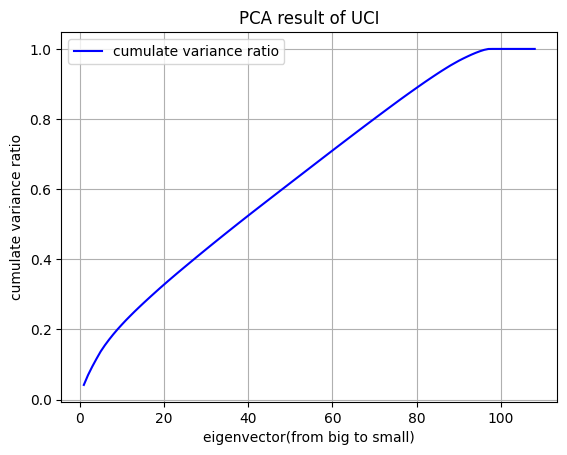

In [ ]:
###Since enocoded dataset is really sparse and high dimensional ## first use PCA to reduce the dimension
from sklearn.decomposition import PCA
p_model=PCA()
p_model.fit(normal_x_pca)
variance_c_ratio=np.cumsum(p_model.explained_variance_)/np.sum(p_model.explained_variance_)
####
for i in range(1,variance_c_ratio.shape[0]):
  if variance_c_ratio[i-1]<=0.95 and variance_c_ratio[i]>0.95:
    use_index=i
    break
##

print(f'The number of eignevector for cumulated 95% variance is :{use_index+1}, stop at eigenvalue: {p_model.explained_variance_[i]}')
plt.plot(np.array([i for i in range(1,p_model.explained_variance_.shape[0]+1)]), variance_c_ratio,'-b',label='cumulate variance ratio')
plt.xlabel('eigenvector(from big to small)')
plt.ylabel('cumulate variance ratio')
plt.title('PCA result of UCI')
plt.legend()
plt.grid()
plt.show()


In [ ]:
### we choose to use 88 principle components
p_model_try=PCA(n_components=0.95)
pca_whole=p_model_try.fit_transform(normal_x_pca)
print(f'new training set shape:{pca_whole.shape}')

new training set shape:(47621, 88)


In [ ]:
### split dataset input train.validation and test set
from sklearn.model_selection import train_test_split
# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(pca_whole, target_list, test_size=0.3,random_state=100,stratify=target_list)
print(f' Training set shape:{x_train.shape}.Testing set shape:{x_test.shape}')

 Training set shape:(33334, 88).Testing set shape:(14287, 88)


In [ ]:
#### first use validation set to search best k
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn_1 = KNeighborsClassifier()
k_range = list(range(1, 51))
param_grid_1 = dict(n_neighbors=k_range)
# defining parameter range
grid = GridSearchCV(knn_1, param_grid_1, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
# fitting the model for grid search
grid_search=grid.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
### print the best n_neightbors based on GridSearchCV
print(grid_search.best_params_)

{'n_neighbors': 35}


In [ ]:
### therefore, we choose n_neightbors=35,weight=unifrom(default),distance metric is p
knn_best=KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
print(f'The final training loss:{1-knn_best.fit(x_train,y_train).score(x_train,y_train)},final testing loss:{1-knn_best.fit(x_train,y_train).score(x_test,y_test)}')
print(f'Final training accuracy:{knn_best.fit(x_train,y_train).score(x_train,y_train)},final testing acccuracy:{knn_best.fit(x_train,y_train).score(x_test,y_test)}')


The final training loss:0.16229675406491872,final testing loss:0.1701546860782529
Final training accuracy:0.8377032459350813,final testing acccuracy:0.8298453139217471


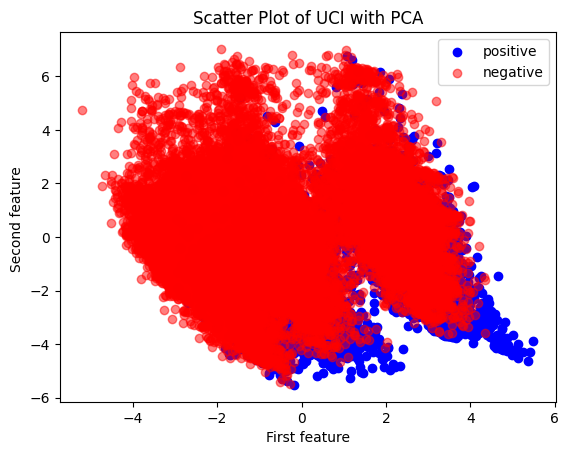

In [ ]:
### scatter plot of best result for first two features

plt.scatter(pca_whole[:,0][target_list==1],pca_whole[:,1][target_list==1],color='blue',alpha=1,label='positive')
plt.scatter(pca_whole[:,0][target_list==0],pca_whole[:,1][target_list==0],color='red',alpha=0.5,label='negative')
plt.xlabel('First feature')
plt.ylabel('Second feature ')
plt.title('Scatter Plot of UCI with PCA')
plt.legend()
plt.show()

(array([0.5, 1.5]), [Text(0.5, 0, '<=50k'), Text(1.5, 0, '>50k')])

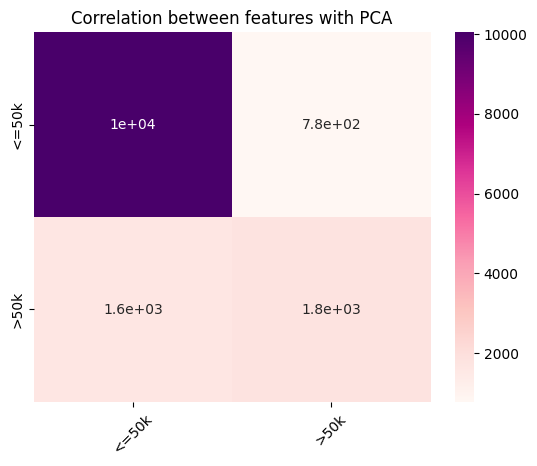

In [ ]:
### change the target result ###
prediction=knn_best.fit(x_train,y_train).predict(x_test)
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test,prediction)
sns.heatmap(mat,annot=True,cmap='RdPu',xticklabels=['<=50k','>50k'],yticklabels=['<=50k','>50k'])
plt.title('Correlation between features with PCA')
plt.xticks(rotation=45)

In [ ]:
precison_pca,recall_pca,f1=PR_met(mat)
print(f'Precision with pca is :{precison_pca},Recall with pca is:{recall_pca},f1 score is:{f1}')

Precision with pca is :0.6984982672314208,Recall with pca is:0.5239745811669555,f1 score is:0.5987786763492327


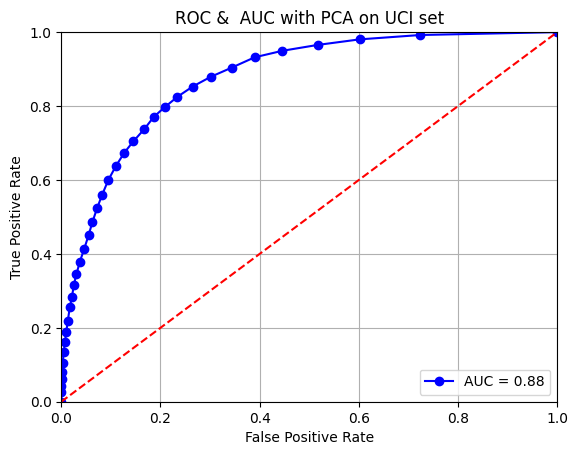

In [ ]:
from sklearn.metrics import auc
y_scores = knn_best.fit(x_train,y_train).predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:,1])
roc_auc =auc(fpr, tpr)

plt.title('ROC &  AUC with PCA on UCI set')
plt.plot(fpr, tpr, 'o-b',alpha=1, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

In [ ]:
### knn directly on encoded dataset after fitting
normal_x_orig=scaler.fit_transform(encoded_x)
# Split dataset into training set and test set
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(normal_x_orig, target_list, test_size=0.3,random_state=100,stratify=target_list)
print(f'On original encoded set: Training set shape:{x_train_2.shape}.Testing set shape:{x_test_2.shape}')

On original encoded set: Training set shape:(33334, 108).Testing set shape:(14287, 108)


In [ ]:
knn_2 = KNeighborsClassifier()
k_range = list(range(1, 51))
param_grid_2 = dict(n_neighbors=k_range)
# defining parameter range
grid_2 = GridSearchCV(knn_2, param_grid_2, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
# fitting the model for grid search
grid_search_2=grid.fit(x_train_2, y_train_2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
### print the best n_neightbors based on GridSearchCV
print(grid_search_2.best_params_)

{'n_neighbors': 41}


In [ ]:
### therefore, we choose n_neightbors=7,weight=unifrom(default),distance metric is p=24
knn_best_2=KNeighborsClassifier(n_neighbors=grid_search_2.best_params_['n_neighbors'])
print(f'The final training loss:{1-knn_best_2.fit(x_train_2,y_train_2).score(x_train_2,y_train_2)},final testing loss:{1-knn_best_2.fit(x_train_2,y_train_2).score(x_test_2,y_test_2)}')
print(f'The final training acc:{knn_best_2.fit(x_train_2,y_train_2).score(x_train_2,y_train_2)},final testing acc:{knn_best_2.fit(x_train_2,y_train_2).score(x_test_2,y_test_2)}')
prediction_2=knn_best_2.fit(x_train_2,y_train_2).predict(x_test_2)

The final training loss:0.16166676666466673,final testing loss:0.17099461048505638
The final training acc:0.8383332333353333,final testing acc:0.8290053895149436


(array([0.5, 1.5]), [Text(0.5, 0, '<=50k'), Text(1.5, 0, '>50k')])

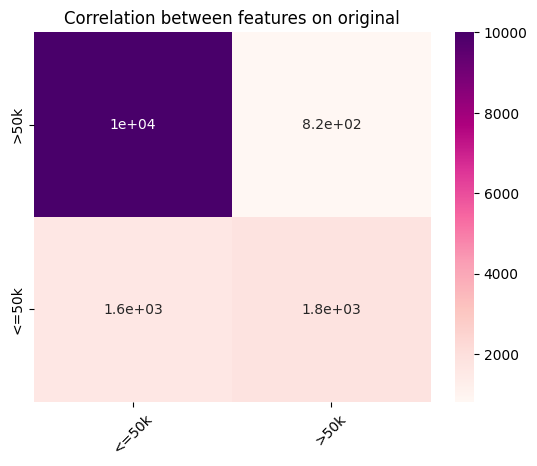

In [ ]:
### change the target result ###
from sklearn.metrics import confusion_matrix
mat_2=confusion_matrix(y_test_2,prediction_2)
sns.heatmap(mat_2,annot=True,cmap='RdPu',xticklabels=['<=50k','>50k'],yticklabels=['>50k','<=50k'])
plt.title('Correlation between features on original')
plt.xticks(rotation=45)

In [ ]:
## metircs on original dataset ###
precison_ori,recall_ori,f1_ori=PR_met(mat_2)
print(f'Precision on original is :{precison_ori},Recall on original is:{recall_ori},f1 on original is :{f1_ori}')

Precision on original is :0.6916133884919142,Recall on original is:0.5311958405545927,f1 on original is :0.6008822087894135


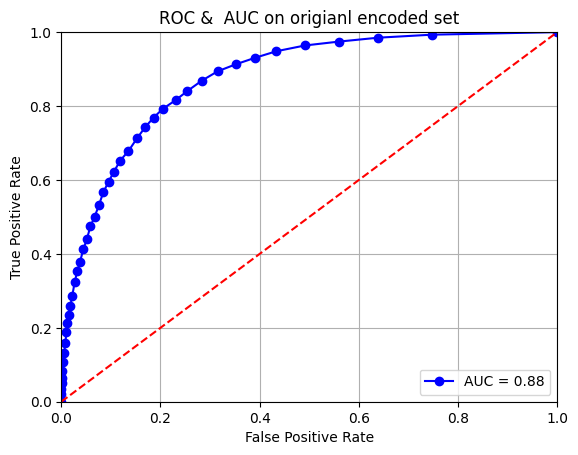

In [ ]:
y_scores_2 = knn_best_2.fit(x_train_2,y_train_2).predict_proba(x_test_2)
fpr_2, tpr_2, threshold_2 = roc_curve(y_test_2, y_scores_2[:,1])
roc_auc =auc(fpr_2, tpr_2)

plt.title('ROC &  AUC on origianl encoded set')
plt.plot(fpr_2, tpr_2, 'o-b',alpha=1, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDS
scaler=SS()
normal_x_orig_3=scaler.fit_transform(encoded_x)
####
# Split dataset into training set and test set
#x_tv_3, x_test_3, y_tv_3, y_test_3 = train_test_split(normal_x_orig_3, target_list, test_size=0.3,random_state=100,stratify=target_list)
###
#### use LDA on training set n_components=1
lds_model=LDS(n_components=1)
x_final=lds_model.fit_transform(normal_x_orig_3,target_list)
print(f'On original Training set shape:{normal_x_orig_3.shape}')
print(f'Transfer datset shape under LDA:{x_final.shape}')
# Split dataset into training set and validation set
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_final, target_list, test_size=0.3,random_state=100,stratify=target_list)
print(f'On original encoded set: Training set shape:{x_train_3.shape}.Testing set shape:{x_test_3.shape}')



On original Training set shape:(47621, 108)
Transfer datset shape under LDA:(47621, 1)
On original encoded set: Training set shape:(33334, 1).Testing set shape:(14287, 1)


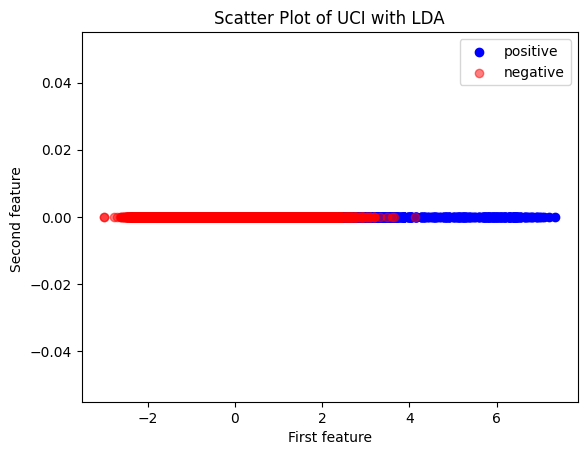

In [ ]:
plt.scatter(x_final[:,0][target_list==1],np.zeros(x_final[target_list==1].shape[0]),color='blue',alpha=1,label='positive')
plt.scatter(x_final[:,0][target_list==0],np.zeros(x_final[target_list==0].shape[0]),color='red',alpha=0.5,label='negative')
plt.xlabel('First feature')
plt.ylabel('Second feature ')
plt.title('Scatter Plot of UCI with LDA')
plt.legend()
plt.show()

In [ ]:
## use the whole validation set to do GridsearchCV to find best K
knn_3 = KNeighborsClassifier()
k_range_3 = list(range(1, 51))
param_grid_3 = dict(n_neighbors=k_range_3)
# defining parameter range
grid = GridSearchCV(knn_3, param_grid_3, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
# fitting the model for grid search
grid_search_3=grid.fit(x_train_3, y_train_3)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
### print the best n_neightbors based on GridSearchCV
print(grid_search_3.best_params_)

{'n_neighbors': 46}


In [ ]:
### therefore, we choose n_neightbors=45,weight=unifrom(default),distance metric is p=24
knn_best_3=KNeighborsClassifier(n_neighbors=grid_search_3.best_params_['n_neighbors'])
print(f'The final training loss:{1-knn_best_3.fit(x_train_3,y_train_3).score(x_train_3,y_train_3)},final testing loss:{1-knn_best_3.fit(x_train_3,y_train_3).score(x_test_3,y_test_3)}')
print(f'The final training acc:{knn_best_3.fit(x_train_3,y_train_3).score(x_train_3,y_train_3)},final testing acc:{knn_best_3.fit(x_train_3,y_train_3).score(x_test_3,y_test_3)}')


The final training loss:0.15500689986200278,final testing loss:0.1620354168124869
The final training acc:0.8449931001379972,final testing acc:0.8379645831875131


(array([0.5, 1.5]), [Text(0.5, 0, '<=50k'), Text(1.5, 0, '>50k')])

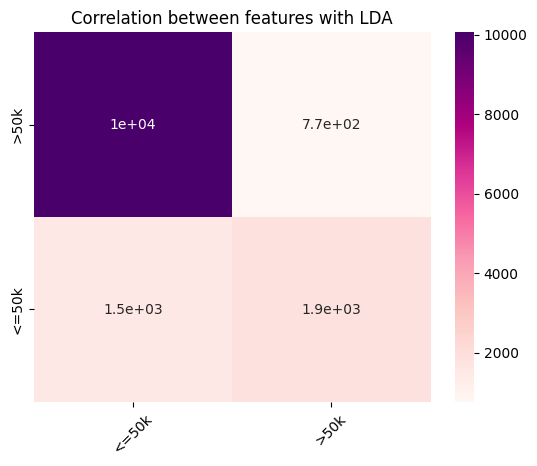

In [ ]:
### change the target result ###
from sklearn.metrics import confusion_matrix
prediction_3=knn_best_3.fit(x_train_3,y_train_3).predict(x_test_3)
mat_3=confusion_matrix(y_test_3,prediction_3)
sns.heatmap(mat_3,annot=True,cmap='RdPu',xticklabels=['<=50k','>50k'],yticklabels=['>50k','<=50k'])
plt.title('Correlation between features with LDA')
plt.xticks(rotation=45)

In [ ]:
## metircs on original dataset ###
precison_lda,recall_lda,f1_lda=PR_met(mat_3)
print(f'Precision with lda is :{precison_lda},Recall with lda is:{recall_lda},F1 score with lda is :{f1_lda}')

Precision with lda is :0.7139127191346513,Recall with lda is:0.5528596187175043,F1 score with lda is :0.6231482988767703


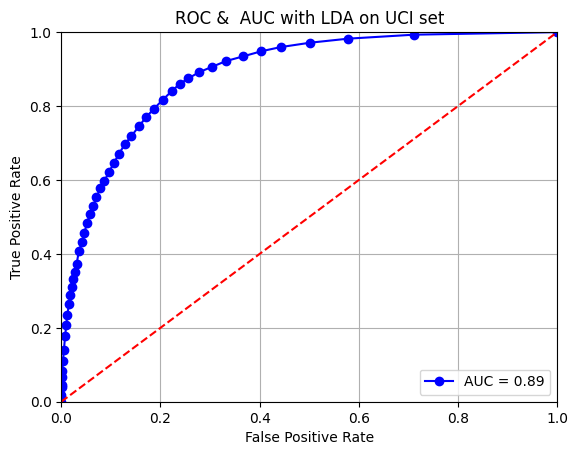

In [ ]:
y_scores_3 = knn_best_3.fit(x_train_3,y_train_3).predict_proba(x_test_3)
fpr_3, tpr_3, threshold_3 = roc_curve(y_test_3, y_scores_3[:,1])
roc_auc =auc(fpr_3, tpr_3)

plt.title('ROC &  AUC with LDA on UCI set')
plt.plot(fpr_3, tpr_3, 'o-b',alpha=1, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()